In [5]:
import datetime as dt  
import numpy as np
from netCDF4 import Dataset  
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
from matplotlib.patches import Path, PathPatch # for making ocean white
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.

    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        """
        try:
            print("\t\ttype:", repr(nc_fid.variables[key].dtype))
            for ncattr in nc_fid.variables[key].ncattrs():
                print('\t\t%s:' % ncattr,\
                      repr(nc_fid.variables[key].getncattr(ncattr)))
        except KeyError:
            print("\t\tWARNING: %s does not contain variable attributes" %key)

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print("NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print('\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print("NetCDF dimension information:")
        for dim in nc_dims:
            print("\tName:", dim)
            print("\t\tsize:", len(nc_fid.dimensions[dim]))
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print("NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print('\tName:', var)
                print("\t\tdimensions:", nc_fid.variables[var].dimensions)
                print("\t\tsize:", nc_fid.variables[var].size)
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

nc_f   = '/data0/dwei/VPRM_XMH/wrfout_d01_surface_ncrcat_2018.nc'  
nc_fid = Dataset(nc_f, 'r')  # Dataset is the class behavior to open the file                
#nc_attrs, nc_dims, nc_vars = ncdump(nc_fid)

# Extract data from NetCDF file
GEE    = nc_fid.variables['EBIO_GEE'][:] # biospheric VPRM CO2 uptake [mol km^-2 hr^-1']
RES    = nc_fid.variables['EBIO_RES'][:] # biospheric VPRM CO2 release [mol km^-2 hr^-1']
time   = nc_fid.variables['XTIME'][:]    # minutes
nc_fid.close()
NEE    = GEE + RES

nc_f   = '/data0/dwei/VPRM_XMH/wrfinput_d01_XLAT_XLONG.nc'  
nc_fid = Dataset(nc_f, 'r')  # Dataset is the class behavior to open the file                

# Extract data from NetCDF file   
lons2   = nc_fid.variables['XLONG'][0, :, :] # convert 3D to 2D
lats2   = nc_fid.variables['XLAT'][0, :, :]
nc_fid.close()

# NYC boundaries in lat and lon
ul = (40.91994359299865, -74.25078580367983)
ll = (40.498429317593086, -74.25549540873544)
ur = (40.915050108690444, -73.70006247106176)
lr = (40.493607634923094, -73.70823210074099)

import pandas as pd
df=pd.read_csv('/data0/dwei/VPRMout/NYC_domain_center_latlon')
#print(df.head())
center_lat = df.to_numpy()[:,1]
center_lon = df.to_numpy()[:,2]


In [8]:
# Calculate monthly 24-hour means of NEE
dt_time = [dt.datetime(2018, 1, 1, 0, 0, 0) + dt.timedelta(hours=int(t/60)) for t in time]
months  = [] 
hours   = []
for date in dt_time:
    months.append(date.month)  
    hours.append(date.hour)
months_arr = np.asarray(months)
hours_arr = np.asarray(hours)
    
def monthly_averages(data, month): # 4D data
    boo = months_arr==month
    return np.nanmean(data[boo, 0, :, :], axis=0)

def monthly_total(data, month): # 4D data
    boo = months_arr==month
    return np.nansum(data[boo, 0, :, :], axis=0)

GEE_jun_avg = monthly_averages(GEE, 6)
RES_jun_avg = monthly_averages(RES, 6)
NEE_jun_avg = monthly_averages(NEE, 6)
GEE_jun_tot = monthly_total(GEE, 6)
RES_jun_tot = monthly_total(RES, 6)
NEE_jun_tot = monthly_total(NEE, 6)

# convert mol km-2 hr-1 to umol m-2s-1
GEE_jun_avg_umol = -GEE_jun_avg/3600.
RES_jun_avg_umol = RES_jun_avg/3600.
NEE_jun_avg_umol = -NEE_jun_avg/3600.
GEE_jun_tot_umol = -GEE_jun_tot/3600.
RES_jun_tot_umol = RES_jun_tot/3600.
NEE_jun_tot_umol = -NEE_jun_tot/3600.

# set water to zero
GEE_jun_avg_umol[GEE_jun_avg_umol==0.0]=np.nan
RES_jun_avg_umol[RES_jun_avg_umol==0.0]=np.nan
NEE_jun_avg_umol[NEE_jun_avg_umol==0.0]=np.nan
GEE_jun_tot_umol[GEE_jun_tot_umol==0.0]=np.nan
RES_jun_tot_umol[RES_jun_tot_umol==0.0]=np.nan
NEE_jun_tot_umol[NEE_jun_tot_umol==0.0]=np.nan

print(np.nanmedian(GEE_jun_tot_umol))
print(np.nanmedian(RES_jun_tot_umol))
print(np.nanmedian(NEE_jun_tot_umol))


2911.863037109375
1401.3887939453125
927.7772216796875


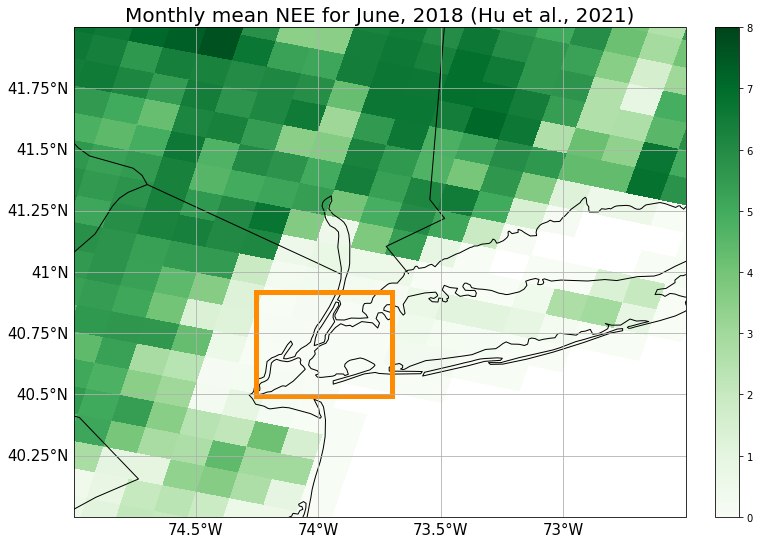

In [74]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker # xticks in gridlines

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

# Plot the monthly data for June, July, and August
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(1,1)
fig.subplots_adjust(hspace=-0.45, wspace=0.05, top=0.95, bottom=0.1, right=0.95, left=0.1)
# map parameters
buff_lon = np.abs(center_lon[0]-center_lon[1])/2.0
buff_lat = np.abs(center_lat[0]-center_lat[1560])/2.0

xul, yul = (min(center_lon)-buff_lon, max(center_lat)+buff_lat)
xll, yll = (min(center_lon)-buff_lon, min(center_lat)-buff_lat)
xur, yur = (max(center_lon)+buff_lon, max(center_lat)+buff_lat)
xlr, ylr = (max(center_lon)+buff_lon, min(center_lat)-buff_lat)
LineColor = 'darkorange'
LineWidth = 5
ColorMap= 'Greens'
Vmin    = 0.0    # lower limit for colormap
Vmax    = 8.0    # upper limit for colormap
extent = [-75, -72.5, 40, 42]

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ June ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.set_title("Monthly mean NEE for June, 2018 (Hu et al., 2021)", fontsize=20)
cc = ax.pcolormesh(lons2, lats2, NEE_jun_avg_umol, 
               transform=ccrs.PlateCarree(),vmin=Vmin, vmax = Vmax, cmap=ColorMap)
# add NYC boundaries
ax.plot([xul, xll], [yul, yll], color=LineColor, linewidth=LineWidth)
ax.plot([xll, xlr], [yll, ylr], color=LineColor, linewidth=LineWidth)
ax.plot([xlr, xur], [ylr, yur], color=LineColor, linewidth=LineWidth)
ax.plot([xur, xul], [yur, yul], color=LineColor, linewidth=LineWidth)
# add buff 
ax.plot([xul, xll], [yul, yll], color=LineColor, linewidth=LineWidth)
ax.plot([xll, xlr], [yll, ylr], color=LineColor, linewidth=LineWidth)
ax.plot([xlr, xur], [ylr, yur], color=LineColor, linewidth=LineWidth)
ax.plot([xur, xul], [yur, yul], color=LineColor, linewidth=LineWidth)

cbar = plt.colorbar(cc, ax=ax,fraction=0.046, pad=0.04)  
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='black')

# Axis labels
gl=ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size':15}
gl.ylabel_style = {'size':15}


In [93]:
# Total GEE, Res, NEE in TgC over the domain per month
MW_C = 12
g2Tg = 1.0E-12
grid_area=12000.*8480.
timestep =3600.0

# Find the pixels in NYC
buff = 0.1/2.0   # set a buffer for half a WRF pixel (~0.05 degree)
boox = [xll-buff<=x_boo<=xur+buff for x_boo in lons2.reshape(265*442)]
booy = [ylr-buff<=y_boo<=yul+buff for y_boo in lats2.reshape(265*442)]
boo = [b1 and b2 for b1,b2 in zip(boox,booy)]
# averages
GEE_jun_avg_1D = GEE_jun_avg_umol.reshape(np.size(GEE_jun_avg_umol))
RES_jun_avg_1D = RES_jun_avg_umol.reshape(np.size(RES_jun_avg_umol))
NEE_jun_avg_1D = NEE_jun_avg_umol.reshape(np.size(NEE_jun_avg_umol))
# sum
GEE_jun_tot_1D = GEE_jun_tot_umol.reshape(np.size(GEE_jun_tot_umol))
RES_jun_tot_1D = RES_jun_tot_umol.reshape(np.size(RES_jun_tot_umol))
NEE_jun_tot_1D = NEE_jun_tot_umol.reshape(np.size(NEE_jun_tot_umol))

GEE_NYC_ave = GEE_jun_avg_1D[boo]
GEE_NYC_std = np.nanstd(GEE_NYC_ave)
GEE_NYC_tot = np.nansum(GEE_jun_tot_1D[boo])

RES_NYC_ave = RES_jun_avg_1D[boo]
RES_NYC_std = np.nanstd(RES_NYC_ave)
RES_NYC_tot = np.nansum(RES_jun_tot_1D[boo])

NEE_NYC_ave = NEE_jun_avg_1D[boo]
NEE_NYC_std = np.nanstd(NEE_NYC_ave)
NEE_NYC_tot = np.nansum(NEE_jun_tot_1D[boo])

# total*grid_area*hourly
GEE_NYC_tot_TgC = GEE_NYC_tot*grid_area*timestep/1.0E6*MW_C*g2Tg
RES_NYC_tot_TgC = RES_NYC_tot*grid_area*timestep/1.0E6*MW_C*g2Tg
NEE_NYC_tot_TgC = NEE_NYC_tot*grid_area*timestep/1.0E6*MW_C*g2Tg

print('Mean ', np.nanmean(GEE_NYC_ave), np.nanmean(RES_NYC_ave), np.nanmean(NEE_NYC_ave))
print('STD  ', GEE_NYC_std, RES_NYC_std, NEE_NYC_std)
print('Total', GEE_NYC_tot_TgC, RES_NYC_tot_TgC, NEE_NYC_tot_TgC)

# # Notes for the results
# Mean  0.6411057 0.3110174 0.12896805
# STD   0.49704304 0.25559992 0.31786233

Mean  0.413479 0.3175973 0.095881715
STD   0.43409505 0.23162055 0.2953283
Total 0.0261744016815 0.020104814466 0.006069586678875


In [84]:
print(GEE_NYC_tot)

[129.0130615234375 1.5870686769485474 13.232885360717773 168.2742156982422
 52.82644271850586 164.77252197265625 60.77179718017578 609.3427734375
 310.953369140625 59.79388427734375 29.198394775390625 297.8165283203125
 490.0805969238281 352.6429138183594 299.9546813964844]


In [79]:
np.shape(GEE_jun_avg_1D)

(117130,)